# Change Detection

In this tutorial we are going to be detecting changes in Satellite imagery captured over time. 

We are going to be using **Landsat 8**. 

We are going to combine the Satelitte data and the power of Python together and be able to visualize these changes within our Notebooks. 

For this to work, you will need to install *jupyter_dashboards* which help you easily visualize these changes within the Notebooks. 

Run the following command in the Jupyter Shell on your machine and make sure you run the shell as an administrator. 

`conda install jupyter_dashboards -c conda-forge -y`

This will install the Dashboard package that helps for visualization. 

- Now as always and as before, we need to login to our GIS. 
- Once we login, we are going to search for the **Landsat Multispectral** imagery layer which is in the ArcGIS Living Atlas platform. 

In [1]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode
from arcgis.raster.functions import *
from arcgis import geometry
    
import pandas as pd

# connect as an anonymous user
gis = GIS('https://arcgis.com', 'kumbirai_matingo')

# search for the landsat multispectral imagery layer
landsat_item = gis.content.search("Landsat Multispectral tags:'Landsat on AWS','landsat 8', 'Multispectral', 'Multitemporal', 'imagery', 'temporal', 'MS'", 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
df = None

## Create Widgets

- we have created a location input box, for the user to enter in their location

But, however, we have prepopulated that location box to contain our default location which currently is Harare in Zimbabwe. 

- we have included a button that allows the user to also accept the location they have entered as the input for the location definition.

The button has the text "Go" which when clicked, the address contained within will be geocoded. 

- we have defined the click action with the `on_gobutton_clicked()` function which we just defined in the code below. 

Within this function, we have defined some global variables for usage later on. 

Definition: In computer programming, a **global variable** is a variable with global scope, meaning that it is visible (hence accessible) throughout the program, unless shadowed. The set of all global variables is known as the global environment or global state.[Source](https://en.wikipedia.org/wiki/Global_variable#:~:text=In%20computer%20programming%2C%20a%20global,global%20environment%20or%20global%20state.)

- within the same function again, we have specified the images we want to be only for the view extend which is the location that was entered in the widget box above. This helps speed up the process unlike when the whole code tries to get every image it can when we do not define an extent and filter. 

- we then call the `Widgets` method to bring up the widgets on our frontend for the users to interact with. And also remember to define an action for the **Go** button. 

In [2]:
import ipywidgets as widgets

# text box widget
location = widgets.Text(value='Harare, Zimbabwe', placeholder='Harare, Zimbabwe',
                        description='Location:', disabled=False)

# command button widget
gobtn = widgets.Button(description='Go', disabled=False,
                       button_style='', tooltip='Go', icon='check')

# define what happens whent the command button is clicked
def on_gobutton_clicked(b):
    global df
    global m
    global oldslider
    
    # geocode the place name and set that as the map's extent
    area = geocode(location.value)[0]
    m.extent = area['extent']
    df = filter_images()
    
gobtn.on_click(on_gobutton_clicked)

location_items = [location, gobtn]
widgets.HBox(location_items)

## Display Our Map

- call the `map()` method and pass the users geocoded input as parameters
- call the `add_layer()` method and pass the landsat imagery as a variable. 

To display we just call the `display()` function and pass the variable that contains our map as a parameter. 

In [3]:
m = gis.map(location.value)
m.add_layer(landsat)
display(m)

MapView(layout=Layout(height='400px', width='100%'))

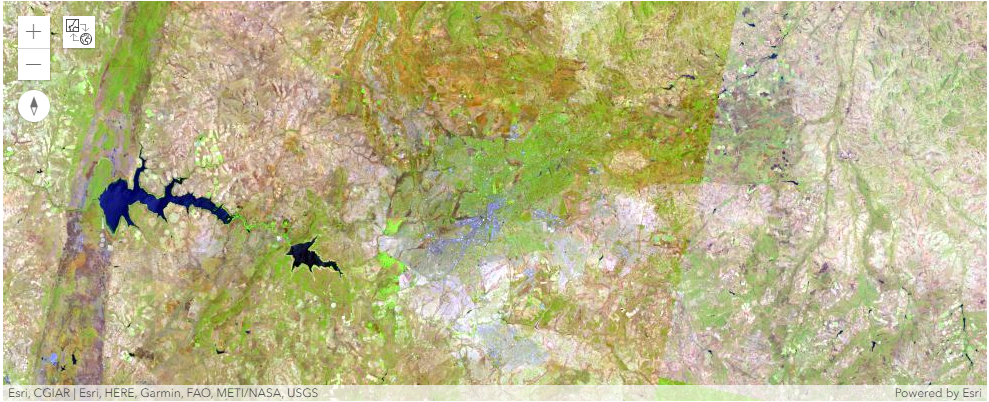

## Create Date Slide Controllers

We are going to create two widgets:

1. Picks Dates Before
2. Picks Dates After 

In both cases, we define an index which starts from the value zero (0)

### Before Image Data Widget 

- we create a variable and name it accordingly 
- using the `widgets` method, we create a slider which the user can use to pick a date for the imagery to show. 

Take note of the parameters which can be configured within this method below. You can play around with them to get an appreciation of how they work. 

- we have created a function that handles the behaviour of the slider widget. 

Here, we are going to put a condition that determines if our slider was moved or not. In the event the slider is moved, a certain action/change in the data/imagery is perfomed according to the newly set parameters. 

At times we might not have any changes so we put the **try** and **except** to handle in case there are any errors within the imagery. We would not want to display the whole error to the users so this will basically handle everything for us. 

- lastly, to display these widgets, we just call the declared variable and pass in some parameters as shown below. 

In [4]:
oldindex =  0 # int(len(df)/2)

# before image date slider
oldslider = widgets.IntSlider(value=oldindex, min=0,max=10, #len(df) - 1,
                              step=1, description='Older:', disabled=False,
                              continuous_update=True, orientation='horizontal',
                              readout=False, readout_format='f', slider_color='white')

old_label = widgets.Label(value='')#str(df.Time.iloc[oldindex].date()))

# define the slider behavior
def on_old_value_change(change):
    global df
    i = change['new']
    if df is not None:
        try:
            # print(df.Time.iloc[i].date())
            old_label.value = str(df.Time.iloc[i].date())
        except:
            pass
        
oldslider.observe(on_old_value_change, names='value')    
widgets.HBox([oldslider, old_label])

### After Image Data

Here, we just do the same like we did with the **Before Image Data** but of course using different variable names. Then we call the variables and pass in some parameters too. 

In [5]:
newindex = 0 # len(df) - 1

# after image date slider
newslider = widgets.IntSlider(value=newindex, min=0, max=10, #len(df) - 1,
                              step=1, description='Newer:', disabled=False,
                              continuous_update=True, orientation='horizontal',
                              readout=False, readout_format='f', slider_color='white')

new_label = widgets.Label(value='') #str(df.Time.iloc[newindex].date()))

# define the slider behavior
def on_new_value_change(change):
    global df
    i = change['new']
    if df is not None:
        try:
        # print(df.Time.iloc[i].date())
            new_label.value = str(df.Time.iloc[i].date())
        except:
            pass
newslider.observe(on_new_value_change, names='value')
widgets.HBox([newslider, new_label])

## Query The Time Enabled Data Set

This function is only responsible for filtering and finding the exact images we need based on the filter from the date slider. 

#### A little explanation on `iloc`

As stated and define in the Python Docs, the `iloc()` function enables us to select a particular cell of the dataset, and it helps us to select a value that belongs to a particular row or column from a set of data. So in our case, we are using `iloc()` to choose a specific date range that we want to visualize on our map. 

The defined `filter_images()` function, is going to be doing the image filtering for us now. 

In [6]:
def update_sliders(tdf):
    global oldslider
    global newslider
    
    oldslider.max = len(tdf) - 1
    newslider.max = len(tdf) -1
    oldindex = int(len(tdf)/2)
    newindex = int(len(tdf) -1)
    oldslider.value = oldindex
    newslider.value = newindex
    old_label.value = str(tdf.Time.iloc[oldindex].date())
    new_label.value = str(tdf.Time.iloc[newindex].date())


def filter_images():
    global df
    area = geocode(location.value, out_sr=landsat.properties.spatialReference)[0]
    extent = area['extent']

    selected = landsat.filter_by(where="(Category = 1) AND (CloudCover <=0.10)", 
                             geometry=geometry.filters.intersects(extent))
    fs = selected.query(out_fields="AcquisitionDate, GroupName, Best, CloudCover, WRS_Row, WRS_Path, Month, Name", 
                  return_geometry=True,
                  return_distinct_values=False,
                  order_by_fields="AcquisitionDate")
    tdf = fs.sdf
    df = tdf
    tdf['Time'] = pd.to_datetime(tdf['AcquisitionDate'], unit='ms')    
    
    if len(tdf) > 1:
        update_sliders(tdf)

    # m.draw(tdf.iloc[oldslider.value].SHAPE)
    
    return tdf

In [7]:
df = filter_images()

## The Detector Button

The whole point of this was to enable us to **detect changes** so here is the final and most important step. 

- we have created a button, which the user must click on order to detect the changes. 

- once button is clicked, the `on_diffbutton_clicked()` function will then begin its execution by clearing the graphics first
- if you have installed the `jupyter_dashboards` library, you will have a clear visual of these changes as you change the dates using the widgets. 

In [8]:
# create the action button
diffbtn = widgets.Button(description='Detect changes', disabled=False,
                         button_style='success', tooltip='Show Different Image',
                         icon='check')

def on_diffbutton_clicked(b):
    # m.clear_graphics()
    first = df.iloc[oldslider.value].OBJECTID
    last = df.iloc[newslider.value].OBJECTID
    old = landsat.filter_by('OBJECTID='+str(first))
    new = landsat.filter_by('OBJECTID='+str(last))
    diff = stretch(composite_band([ndvi(old, '5 4'),
                               ndvi(new, '5 4'),
                               ndvi(old, '5 4')]), 
                               stretch_type='stddev',  num_stddev=3, min=0, max=255, dra=True, astype='u8')
    m.add_layer(diff)
    
diffbtn.on_click(on_diffbutton_clicked)
diffbtn

Button(button_style='success', description='Detect changes', icon='check', style=ButtonStyle(), tooltip='Show …

That's how you can create a change detection app with these Python for ArcGIS API Notebooks. 

Hopefully you can get to analyse satellite data without going through any hustles that might be stressful. 

If you didn't face any errors along the way then;

### CONGRATULATIONS 

![Congratulations](https://media1.giphy.com/media/3oz9ZE2Oo9zRC/200.gif)


You've managed to complete your step in **#CreatingAnAppWithJupyterNotebooks**

For anyone having trouble or fails to understand this tutorial, I am reachable via [LinkedIn](https://www.linkedin.com/in/kumbirai-matingo-6910a617a/). Just send me a direct message and I will be sure to respond to any questions relating to the tutorials that you might have. 

## About Author 

![Kumbirai Matingo.jpg](https://pbs.twimg.com/profile_images/1348641760575168515/NalgUV_9_200x200.jpg)

- 3rd Year BSc Hons in Surveying & Geomatics
- Interested in GIS for Health and Land Administration, Spatial Data Science and Programming 
- You can download my Resume online too. Just click [here](https://africansurveyors.net/images/Resume%20for%20Kumbirai%20Matingo.pdf)  